# Calculate the Initial Stake Needed

The key factor in effectively implementing a blind slashing system is determining the appropriate initial stake. Setting the initial capital too high could deter individuals from entering the marketplace, while setting it too low increases the risk of users facing financial ruin. The challenge lies in finding the optimal balance: the initial stake should be high enough to deter attackers or careless users by making it costly for them to make the platform fault prone, but not so high that it discourages potential users from participating.

# Using the Classic Cramér–Lundberg Model

The Cramér-Lundberg model is a mathematical model used in risk theory and actuarial science to describe the evolution of an insurer's surplus over time. The model provides a framework for analyzing the probability of ruin, which occurs when the insurer's surplus becomes negative. What we did earlier is a simplification of this model. The main difference being the way we compute capital over time and the use of a Poisson law to set the number of claims per time period. We can use it in order to try and find the right staking amount.  

### Key Components

1. **Initial Capital ($u$)**: The initial amount of money the insurer has.
2. **Premiums ($P_i$)**: Regular income received by the insurer over time.
3. **Claims ($C_j$)**: Payments made by the insurer when insured events occur.
4. **Claim Frequency ($\lambda$)**: The rate at which claims occur, typically modeled using a Poisson process.
5. **Claim Severity**: The size of the claims, often modeled using a normal or exponential distribution.

### Surplus Process

The surplus process $ U(t) $ describes the insurer's capital at time $ t $:
$$ U(t) = u + \sum_{i=1}^{N_t} P_i - \sum_{j=1}^{M_t} C_j $$

- $ u $ is the initial capital.
- $ N_t $ is the number of premium payments received by time $ t $.
- $ M_t $ is the number of claims by time $ t $.
- $ P_i $ are the premiums.
- $ C_j $ are the claims.

### Probability of Ruin

The probability of ultimate ruin $ \Psi(u) $ is the probability that the surplus process $ U(t) $ will eventually fall below zero:
$$ \Psi(u) = \text{P}( \exists t \geq 0 \text{ such that } U(t) < 0 ) $$

We will estimate the probability of ruin by running many simulations (Monte Carlo method), then we can estimate the probability of ruin 𝜓(𝑢) by counting the fraction of simulations where the capital drops below zero.  

## Application in Python Code

Let's start with a basic simulation.  

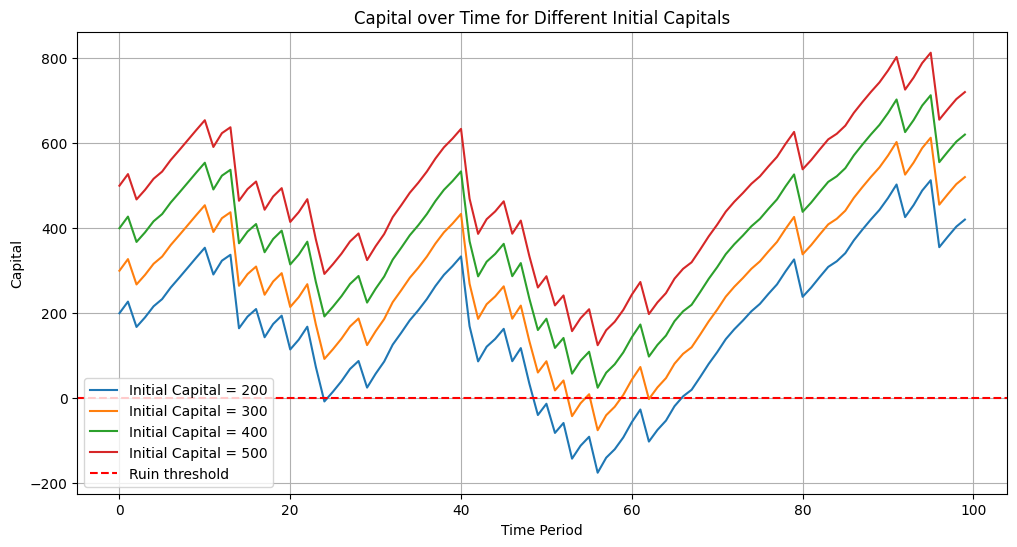

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
claim_frequency = 0.2  # Frequency of claims (per time unit)
mean_claim = 100  # Mean size of claims
mean_premium = 25  # Mean size of premiums
time_periods = 100  # Number of time periods to simulate
initial_capitals = [200, 300, 400, 500]  # Different initial capital amounts

# Simulation
np.random.seed(23)  # For reproducibility

# Generate the number of claims per time period
claims_per_period = np.random.poisson(claim_frequency, time_periods)

# Generate the claim amounts for each period
claim_amounts = np.random.normal(mean_claim, np.sqrt(100), time_periods)

# Generate the premium amounts for each period
premium_amounts = np.random.normal(mean_premium, np.sqrt(25), time_periods)

# Plot settings
plt.figure(figsize=(12, 6))

# Loop through different initial capital amounts
for initial_capital in initial_capitals:
    # Calculate the capital over time for the current initial capital
    capital_over_time = np.zeros(time_periods)
    capital_over_time[0] = initial_capital

    for t in range(1, time_periods):
        # Calculate total claims for the current period
        total_claims = np.sum(claim_amounts[:t] * claims_per_period[:t])
        # Calculate total premiums for the current period
        total_premiums = np.sum(premium_amounts[:t])
        # Update capital
        capital_over_time[t] = initial_capital + total_premiums - total_claims

    # Plot the capital over time for the current initial capital
    plt.plot(capital_over_time, label=f'Initial Capital = {initial_capital}')

# Plot settings
plt.axhline(y=0, color='r', linestyle='--', label='Ruin threshold')
plt.xlabel('Time Period')
plt.ylabel('Capital')
plt.title('Capital over Time for Different Initial Capitals')
plt.legend()
plt.grid(True)
plt.show()


Let's repeat the simulation many time at different amount of initial capital in a monte-carlo fashion to find out the probability of ruin.  

In [6]:
# Parameters
claim_frequency = 0.2  # Frequency of claims (per time unit)
mean_claim = 100  # Mean size of claims
claim_std_dev = 10  # Standard deviation of claims
mean_premium = 25  # Mean size of premiums
premium_std_dev = 5  # Standard deviation of premiums
time_periods = 100  # Number of time periods to simulate
initial_capitals = [10, 20, 30 , 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 250, 300, 350, 400, 450, 500, 1000]  # Different initial capital amounts
num_simulations = 1000  # Number of simulations

# Simulation
# np.random.seed(23)  # Not setting seed for Monte Carlo simulations

# Function to perform one simulation of the risk process
def simulate_risk_process(initial_capital):
    capital_over_time = np.zeros(time_periods)
    capital_over_time[0] = initial_capital

    for t in range(1, time_periods):
        # Number of claims in this period
        num_claims = np.random.poisson(claim_frequency)
        # Total claim amount for this period
        total_claims = np.sum(np.random.normal(mean_claim, claim_std_dev, num_claims))
        # Total premium for this period
        total_premiums = np.random.normal(mean_premium, premium_std_dev)
        # Update capital
        capital_over_time[t] = capital_over_time[t-1] + total_premiums - total_claims

    return capital_over_time

# Plot settings
plt.figure(figsize=(12, 6))

# Loop through different initial capital amounts
for initial_capital in initial_capitals:
    ruin_count = 0  # Counter for number of simulations resulting in ruin
    for _ in range(num_simulations):
        capital_over_time = simulate_risk_process(initial_capital)
        if np.any(capital_over_time < 0):  # Check if capital goes below zero at any point
            ruin_count += 1
    
    # Probability of ruin
    ruin_probability = ruin_count / num_simulations
    print(f'Initial Capital = {initial_capital}, Ruin Probability = {ruin_probability:.4f}')

Initial Capital = 10, Ruin Probability = 0.7230
Initial Capital = 20, Ruin Probability = 0.7350
Initial Capital = 30, Ruin Probability = 0.6930
Initial Capital = 40, Ruin Probability = 0.6570
Initial Capital = 50, Ruin Probability = 0.6500
Initial Capital = 60, Ruin Probability = 0.6450
Initial Capital = 70, Ruin Probability = 0.5700
Initial Capital = 80, Ruin Probability = 0.5470
Initial Capital = 90, Ruin Probability = 0.5030
Initial Capital = 100, Ruin Probability = 0.5230
Initial Capital = 110, Ruin Probability = 0.4900
Initial Capital = 120, Ruin Probability = 0.4540
Initial Capital = 130, Ruin Probability = 0.4460
Initial Capital = 140, Ruin Probability = 0.4200
Initial Capital = 150, Ruin Probability = 0.3830
Initial Capital = 200, Ruin Probability = 0.3140
Initial Capital = 250, Ruin Probability = 0.2280
Initial Capital = 300, Ruin Probability = 0.2080
Initial Capital = 350, Ruin Probability = 0.1700
Initial Capital = 400, Ruin Probability = 0.1160
Initial Capital = 450, Ruin P

<Figure size 1200x600 with 0 Axes>

Using Monte Carlo simulation, we can determine the ruin probability associated with different initial capital amounts. Based on these probabilities and the level of risk we are willing to accept, we can decide the appropriate amount of initial capital to require from users.